# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)#~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [9]:
spl.hyperparameters

Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836)

In [10]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 718.9169918975681
eps: 0.25 --> VarE: 13.652700992121188
eps: 0.125 --> VarE: 26.07439057604714
eps: 0.0625 --> VarE: 9.692175753169487
eps: 0.03125 --> VarE: 1.788077245258914


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.02420174494400248
samples: 243--> ESS: 0.028707048281663587
samples: 447--> ESS: 0.024904588724533033


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.23396705785591054, 1.0037842782005415, 0.0, 8.633381135133723]
 [0.23396705785591054, 1.0037842782005415, 0.14828385792420384, 10.246532408674677]
 [0.23425318413579527, 0.9870561277647479, 4.285348575475202, 12.786498343500812]
 [0.23426556375394633, 0.9558272149313087, 6.902911409097607, 14.627803438743678]
 [0.23425059744262436, 0.9246080370433409, 4.813141868490295, 15.766258245217923]
 [0.23421761473189573, 0.8935077707036856, 2.713039812556646, 16.208001543306064]
 [0.23420945594023898, 0.8622668994147273, 0.6318939820561784, 15.954037317174741]
 [0.2341657797059819, 0.831279106442439, -1.4548103993522687, 15.001214079140379]
 [0.23419220098936072, 0.8001247479042133, -3.487184855832357, 13.370500097006332]
 [0.2341388094647186, 0.7692668092627719, -3.7464950244834334, 11.977765777252229]
 [0.23387385045683817, 0.7496904913551496, -0.19205536812694568, 13.987783230639337]
 [0.2337715871289948, 0.7795105251880113, 5.159417568941523, 15.40899835237954

In [11]:
#plt.plot(samples_mchmc.E[8000:end])

In [12]:
#mean(samples_mchmc.E[8000:end])

In [13]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [14]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

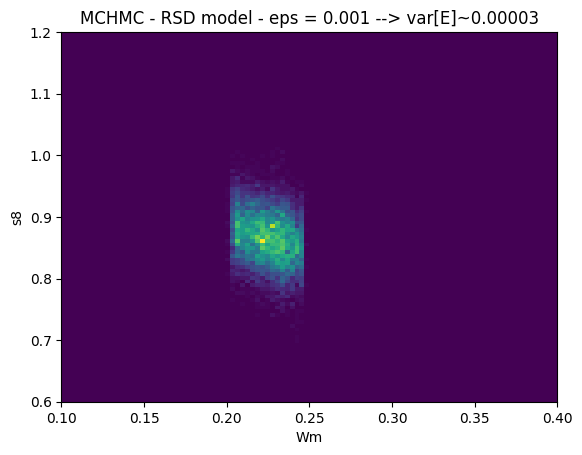

In [15]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [16]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 607.2082449627586
eps: 0.25 --> VarE: 4.15153311166842
eps: 0.125 --> VarE: 21.90433188616749
eps: 0.0625 --> VarE: 2.7779522536302115
eps: 0.03125 --> VarE: 0.2919618018054116
samples: 100--> ESS: 0.027667328169389854
samples: 243--> ESS: 0.01056060257517546
samples: 447--> ESS: 0.005090537143409467
samples: 739--> ESS: 0.013771485578164279


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.21 seconds
Compute duration  = 2.21 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2232    0.0141     0.0001    0.0013     49.0966    1.0264    ⋯
          σ8    0.8672    0.0397     0.0004    0.0011   2792.3231    1.0022    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2024    0.2113    0.2212    0.2344    0.2486
          σ8    0.7904    0.8406    0.8669    0.8930    0.9457


In [17]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.11 seconds
Compute duration  = 1.11 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2231    0.0145     0.0001    0.0014     36.2803    1.0001    ⋯
          σ8    0.8676    0.0409     0.0004    0.0012   2723.0893    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2005    0.2103    0.2233    0.2354    0.2467
          σ8    0.7855    0.8410    0.8675    0.8946    0.9481


## Parallelization

In [18]:
using Distributed

In [19]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 170.11990456568182
eps: 0.25 --> VarE: NaN
eps: 0.125 --> VarE: 28.196059548354164
eps: 0.0625 --> VarE: 14.40088521203764
eps: 0.03125 --> VarE: 2.711982044849889
eps: 0.015625 --> VarE: 1.1531623646951863


[ Info: Found eps: 0.015625 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.021400626525358787
samples: 243--> ESS: 0.009343679320590615
samples: 447--> ESS: 0.01776307870281416
samples: 739--> ESS: 0.014219214785413287


[ Info: Found L: 1.4142135623730951 ✅
chain 3:   2%|█                                         |  ETA: 0:00:04
chain 1:   3%|█▎                                        |  ETA: 0:00:04
chain 2:   3%|█▎                                        |  ETA: 0:00:04
chain 4:   3%|█▎                                        |  ETA: 0:00:04
chain 3:   6%|██▎                                       |  ETA: 0:00:04

chain 1:   6%|██▊                                       |  ETA: 0:00:03
chain 4:   6%|██▊                                       |  ETA: 0:00:03
chain 2:   6%|██▊                                       |  ETA: 0:00:03
chain 3:   8%|███▋                                      |  ETA: 0:00:03
chain 1:  10%|████▎                                     |  ETA: 0:00:03
chain 4:  10%|████▎                                     |  ETA: 0:00:03
chain 2:  10%|████▎                                     |  ETA: 0:00:03
chain 3:  12%|████▉                                     |  ETA: 0:00:03
chain 1:  13%|█████▌     

chain 3:  78%|████████████████████████████████▌         |  ETA: 0:00:01
chain 4:  86%|████████████████████████████████████▍     |  ETA: 0:00:00
chain 1:  86%|████████████████████████████████████▍     |  ETA: 0:00:00
chain 2:  86%|████████████████████████████████████▏     |  ETA: 0:00:00
chain 3:  80%|█████████████████████████████████▊        |  ETA: 0:00:01
chain 4:  90%|█████████████████████████████████████▋    |  ETA: 0:00:00
chain 1:  90%|█████████████████████████████████████▋    |  ETA: 0:00:00
chain 2:  89%|█████████████████████████████████████▍    |  ETA: 0:00:00
chain 3:  84%|███████████████████████████████████▏      |  ETA: 0:00:01
chain 4:  92%|██████████████████████████████████████▉   |  ETA: 0:00:00
chain 1:  93%|███████████████████████████████████████   |  ETA: 0:00:00

chain 2:  92%|██████████████████████████████████████▉   |  ETA: 0:00:00
chain 3:  86%|████████████████████████████████████▍     |  ETA: 0:00:00

chain 4:  96%|████████████████████████████████████████▍ |  ETA

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [ ]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

## NUTS

In [22]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling:   2%|▊                                        |  ETA: 0:00:06┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   3%|█▎                                       |  ETA: 0:00:08┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 6.29 seconds
Compute duration  = 6.29 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2243    0.0143     0.0001    0.0002   7024.7357    1.0000    ⋯
          σ8    0.8661    0.0385     0.0004    0.0005   7141.8802    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [23]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.230875  0.797464  14.8891   3.0  1.0  …  2.0  0.0  1.14262  1.14262
 0.202456  0.897768  14.6385  15.0  1.0     3.0  0.0  1.14262  1.14262
 0.201766  0.905779  14.2329   1.0  1.0     1.0  0.0  1.14262  1.14262
 0.201766  0.905779  14.2329   7.0  1.0     2.0  0.0  1.14262  1.14262
 0.203508  0.85799   14.8287   3.0  1.0     1.0  0.0  1.14262  1.14262
 0.227266  0.956604  13.2923   3.0  1.0  …  2.0  0.0  1.14262  1.14262
 0.228948  0.841929  16.2097   3.0  1.0     2.0  0.0  1.14262  1.14262
 0.228948  0.841929  16.2097   3.0  1.0     1.0  0.0  1.14262  1.14262
 0.237973  0.825316  15.698    1.0  1.0     1.0  0.0  1.14262  1.14262


In [24]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

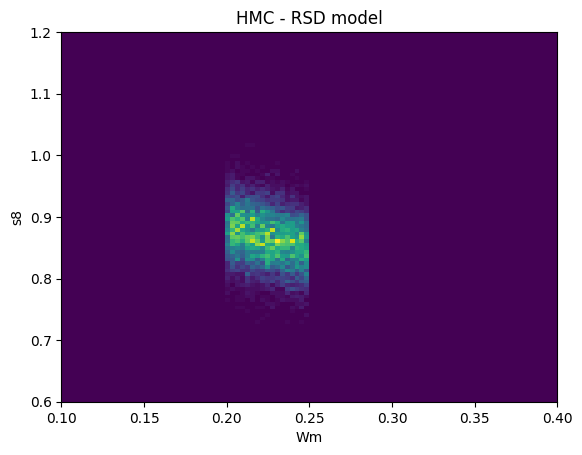

In [25]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");